![Curso de Visión Artificial](imagenes/encabezado.png)




In [1]:
# Siempre que usemos matplotlib en Jupyter es necesario poner esta línea antes de cualquier otra
%matplotlib inline

# Importamos las bibliotecas necesarias y les asignamos un alias
import skimage                           # Biblioteca para la manipulación de imágenes
import numpy as np                       # Biblioteca para la manipulación de matrices

# Importamos algunos paquetes específicos
from matplotlib import pyplot as plt     # Biblioteca para crear gráficas y mostrar las imágenes en pantalla

from skimage import data                 # Paquete con imágenes de prueba
from skimage import io                   # Paquete para lectura/escritura de imágenes
from skimage import color                # Paquete con las operaciones de transformaciones entre espacios de color
from skimage import exposure             # Paquete con las funciones para calcular y alterar el histograma
from skimage import filters              # Paquete que contiene las máscaras y filtros de suavizado y realzado
from skimage import util                 # Paquete que contiene las funciones para cambiar el tipo de dato de las imágenes
from skimage import morphology           # Para crear el kernel de convolución en los filtros no lienales
from skimage import transform            # Esta biblioteca es la que contiene la implementación de Hough
from skimage import measure              # Esta biblioteca contiene el método de etiquetado de regiones
from skimage import feature              # Esta biblioteca es la que contiene la implementación del canny
from skimage import segmentation

from scipy import ndimage                # Usamos esta biblioteca para realizar la operación de convolución
import skdemo                            # Paquete ESPECIAL ADJUNTO con algunas funciones extra de visualización

###########################

from scipy.stats import kde              # Esta biblioteca es necesaria para estimar la función de densidad de los datos
from sklearn import preprocessing        # Este paquete contiene las funciones de preprocesamiento de datos
from sklearn import feature_selection    # Este paquete contiene los métodos de selección de características de sklearn
from sklearn import svm                  # Este paquete contiene las funciones de un clasificador SVM
from sklearn import model_selection      # Este paquete contiene las funciones de particionamiento de datos y validación cruzada
from sklearn import metrics              # Este paquete contiene las funciones para evaluar un clasificador
from sklearn import neighbors  
from sklearn import discriminant_analysis
from sklearn import cluster
from sklearn import naive_bayes
from sklearn import tree
from sklearn import neural_network

# Con este nos aseguramos que las imágenes en niveles de gris, se vean como tal siempre.
# Reiniciamos los parámetros de visualización
plt.rcParams.update(plt.rcParamsDefault)

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'


import pandas as pd
import seaborn as sns


## Preprocesamiento


### 1. Recorte del Diente:
Lo primero que debemos hacer es recortar el diente, que para este proyecto es el primer objeto de interés. La siguiente función hace dichop trabajo.


In [4]:
def recortarDiente(img):

    # Se segmenta la imagen
    t = filters.threshold_minimum(img)
    label_img = measure.label(img > t)
    
    # Se obtienen las caracetrísticas de los objetos
    props = measure.regionprops(label_img)
    
    # Se obtien las áraes de los objetos y el idx del objeto más grande
    areas = [r.area for r in props]
    largest_ind = np.argmax(areas)
    
    # Se obtienen las coordenadas del objeto de mayor área
    x1 = props[largest_ind].bbox[0]
    x2 = props[largest_ind].bbox[2]
    y1 = props[largest_ind].bbox[1]
    y2 = props[largest_ind].bbox[3]

    # Se recorta la imagen
    img_cut = img[x1:x2, y1:y2].copy()
    
    #Para visualizar los resultados del recorte
    #fig, ax = plt.subplots(1,2)
    #ax[0].imshow(label_img, cmap="jet")
    #ax[1].imshow(img_cut, cmap="gray")
    #plt.show()
    
    return skimage.util.img_as_ubyte(img_cut)

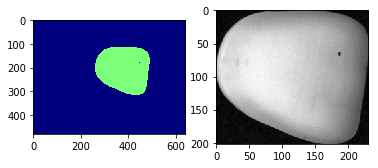

In [3]:
#Prueba de la función
img_color = io.imread("TeethDataset/Dientes_SinGroundTruth/Sucios/2.bmp")
img = color.rgb2gray(img_color)
img_cut = recortarDiente(img)

### 2. Preprocesamiento
Esta función se encarga de preprocesar las imágenes de los dientes. En este sentido, se aplica un filtro mínimo y luego  una expansión del histograma a fin de realzar las zonas oscuras.

In [7]:
def preprocesarDiente(img):
    # Para resaltar los defectos (que son más oscuros) se aplica un filtro mínimo de 3x3
    img2 = filters.rank.minimum(img, selem=np.ones((3,3)))
    
    # Ahora se aplica una expansión para mejorar la separación entre las partes oscuras y claras
    img3 = exposure.rescale_intensity(img2)
    
    # Para visualizar los resultados
    #skdemo.imshow_all(img, img2, img3, titles=["Original", "Mínimo", "Expansión"])
    #plt.show()
    
    return img3

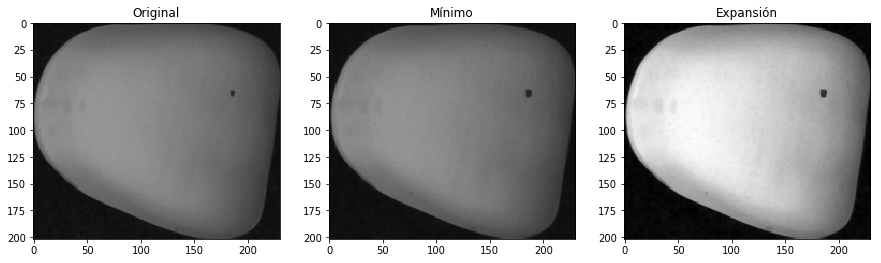

In [6]:
img_pre = preprocesarDiente(img_cut)

### 3. Segmentación de los posibles defectos

Con esta función lo que buscamos es aislar (segmentar) los posibles defectos en los dientes (nuestro objeto de interés en el diente).

In [12]:
def segmentarDefectos(img):
    
    t1 = filters.threshold_mean(img)
    img_bw1 = img < t1
    
    #img_bw2 = filters.scharr(img) > 0.05
    
    #t3 = filters.threshold_sauvola(img, window_size=15)
    #img_bw3 = img > t3
    
    # Visualización para seleccionar el método de segmentación
    #fig, ax = plt.subplots(1,4, figsize=(10,8))
    #ax[0].imshow(img, cmap="gray")
    #ax[1].imshow(measure.label(img_bw1), cmap="jet")
    #ax[2].imshow(measure.label(img_bw2), cmap="jet")
    #ax[3].imshow(measure.label(img_bw3), cmap="jet")
    
    t4 = filters.threshold_minimum(img)
    img_bw4 = img > t4
    img_bw4 = morphology.closing(img_bw4,selem=morphology.disk(6))
    
    # AND entre las dos segmentaciones complementarias
    img_bw = img_bw1 * img_bw4
    
    # Remuevo los objetos que están tocando el borde
    label_img = measure.label(img_bw)
    label_img = segmentation.clear_border(label_img)
    
    #props = measure.regionprops(label_img)
    #areas = [r.area for r in props]
    #largest_ind = np.argmax(areas)
    #label_img[label_img == props[largest_ind].label] = 0
    
    #fig, ax = plt.subplots(1,4, figsize=(20,20))
    #ax[0].imshow(img, cmap="gray")
    #ax[1].imshow(img_bw1, cmap="gray")
    #ax[2].imshow(img_bw4, cmap="gray")
    #ax[3].imshow(label_img, cmap="jet")
    #plt.show()    
    
    return label_img

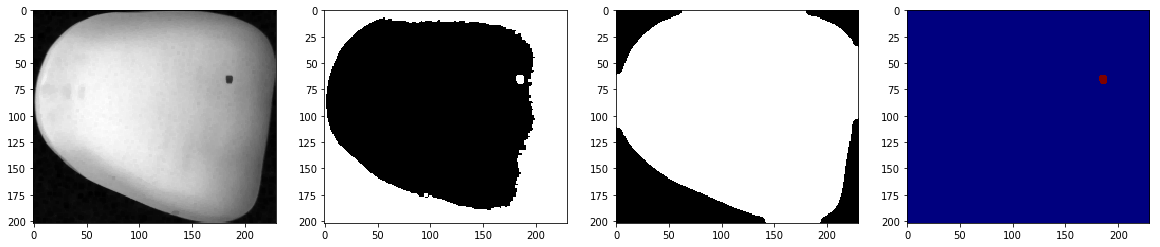

In [11]:
img_lb = segmentarDefectos(img_pre)

### 4. Genere la matriz de características y el vector de etiquetas

Por cada objeto en la imagen se calculan las características y se genera el vector de etiquetas.

In [13]:
def obtenerCaracteristicas(label_img, img, gr_img=None, training=False):

    # Creamos la matriz de datos vacía y el vector de etiquetas
    X = None
    y = None
    img_temp = None
    M = np.unique(label_img).size - 1
    
    #fig, ax = plt.subplots(1,3, figsize=(10,8))
    #ax[0].imshow(img, cmap="gray")
    #ax[1].imshow(label_img, cmap="gray")
    #ax[2].imshow(gr_img, cmap="gray")
    #plt.show()
    
    # Si es para entrenar se genera el vector de etiquetas
    if (training):        
        # Se crea el vector de etiquetas con valor 0 (Clase NO DEFECTO)
        if (M > 0):
            y = np.zeros((M, 1))

        # Se verifica si hay ground_truth
        if (not(gr_img is None)):
            img_temp = label_img[gr_img > 0]

    # Se crea un arreglo con los nombres de las características a calcular
    Xn = np.array(["Area",
                  "Perimetro",
                  "Solidez", 
                  "Excentricidad", 
                  "Centroide X",
                  "Centroide Y",
                  "Diametro Equiv", 
                  "Eje Mayor", 
                  "Eje Menor", 
                  "m1",
                  "m2",
                  "m3",
                  "m4",
                  "m5",
                  "m6",
                  "m7",
                  "max_intensity",
                  "mean_intensity",
                  "min_intensity"
                  ])

    if (M > 0):
        # Lo que debemos hacer es recorrer cada objeto e ir concatenado las características de estos
        i = 0
        props = measure.regionprops(label_img, img)
        for obj in props:
            X_obj = np.array([
                        obj.area,
                        obj.perimeter,
                        obj.solidity,        
                        obj.eccentricity,
                        obj.centroid[0],
                        obj.centroid[1],
                        obj.equivalent_diameter,
                        obj.major_axis_length,
                        obj.minor_axis_length,
                        obj.moments_hu[0],
                        obj.moments_hu[1],
                        obj.moments_hu[2],
                        obj.moments_hu[3],
                        obj.moments_hu[4],
                        obj.moments_hu[5],
                        obj.moments_hu[6],
                        obj.max_intensity,
                        obj.mean_intensity,
                        obj.min_intensity
            ])

            #Agregamos las características del objeto a la matriz X
            if X is None:
                X = X_obj.copy()
            else:
                X = np.vstack((X, X_obj))
            
            #Si es para entrenar se genera el vector de etiquetas
            if (training and not(img_temp is None)):
                if (np.any(img_temp == obj.label)):
                    y[i] = 1
            
            i = i+1

    return X,y,Xn

### 5. Aplique el proceso para todas las imágenes

El proceso debe ser el mismo para todas las imágenes. En este caso se hace dos veces: para las imágenes de los dientes con defectos y para las imágenes de los dientes sin defectos. A finalizar se obtiene la matriz de datos para entrenar un claificador.

In [14]:
# Matriz de datos y vector de etiquetas
X = None
y = None

# Procesamos todas las imágenes de dientes que tienen defectos
for i in range(344):
    #Para las imagenes sin recortar
    #img = color.rgb2gray(io.imread("TeethDataset/Dientes_SinGroundTruth/Sucios/"+str(i+1)+".bmp"))
    #img = recortarDiente(img)
    
    #Para las imagágenes ya recortadas
    img = color.rgb2gray(io.imread("TeethDataset/DientesRecortadosConGroundTruth/Sucios/"+str(i+1)+".bmp"))
    gr_img = skimage.img_as_bool(io.imread("TeethDataset/DientesRecortadosConGroundTruth/Sucios/"+str(i+1)+"_gt.bmp"))
    
    img_2 = preprocesarDiente(img)
    label_img = segmentarDefectos(img_2)
    
    #Se extraen las caracterrísticas de cada uno de los objetos en la imagen obtenida
    a, b, Xn = obtenerCaracteristicas(label_img, img_2, gr_img=gr_img, training=True)
    
    #Se concatenan las caracteristicas de los obj a la matriz de datos
    if not(a is None):
        if X is None:
            X = a.copy()
            y = b.copy()
        else:
            X = np.vstack((X, a))
            y = np.vstack((y, b))


# Procesamos todas las imágenes de dientes sin defectos
for i in range(200):
    #Para las imagenes sin recortar
    #img = color.rgb2gray(io.imread("TeethDataset/Dientes_SinGroundTruth/Buenos/"+str(i+1)+".bmp"))
    #img = recortarDiente(img)
    
    #Para las imagágenes ya recortadas
    img = color.rgb2gray(io.imread("TeethDataset/DientesRecortadosConGroundTruth/Buenos/"+str(i+1)+".bmp"))
    gr_img = skimage.img_as_bool(io.imread("TeethDataset/DientesRecortadosConGroundTruth/Buenos/"+str(i+1)+"_gt.bmp"))
    
    img_2 = preprocesarDiente(img)
    label_img = segmentarDefectos(img_2)
    
    #Se extraen las caracterrísticas de cada uno de los objetos en la imagen obtenida
    a, b, Xn = obtenerCaracteristicas(label_img, img_2, gr_img=gr_img, training=True)
    
    #Se concatenan las caracteristicas de los obj a la matriz de datos
    if not(a is None):
        if X is None:
            X = a.copy()
            y = b.copy()
        else:
            X = np.vstack((X, a))
            y = np.vstack((y, b))

            


### 6. Análizamos las características

En este caso, damos un vistaso rápido a las características y seleccionamos las mejores usando la selección automática.

In [15]:
#Visualizamos el espacio de características usando seaborn
# Empezamos juntando el vector de etiquetas al conjunto de datos
#a = np.hstack((X,y))

# Craemos una estructura llamada DataFrame con los datos y los nombres de las características
#df = pd.DataFrame(data=a, columns=np.hstack((Xn, ['y'])))
                  
# Usamos el paquete seaborn para visualizar las características
#sns.pairplot(df, vars=Xn, diag_kind='kde', hue="y", markers=["o", "^"], palette="muted")
#plt.show()

### 7. Procedemos a entrenar y comparar diferentes modelos de clasificación

In [16]:
#Escalamos los datos
scl = preprocessing.StandardScaler()
scl.fit(X)
X_std = scl.transform(X)

#Usamos validación cruzada y probamos diferentes modelos de clasificación
clfs = []
clfs.append(('LDA', discriminant_analysis.LinearDiscriminantAnalysis()))
clfs.append(('QDA', discriminant_analysis.QuadraticDiscriminantAnalysis()))
clfs.append(('KNN', neighbors.KNeighborsClassifier(n_neighbors=3)))
clfs.append(('Árbol de decisión', tree.DecisionTreeClassifier(max_depth=5)))
clfs.append(('NB', naive_bayes.GaussianNB()))
clfs.append(('SVM Lineal', svm.SVC(C=1, kernel="linear")))
clfs.append(('SVM RBF', svm.SVC(C=1, kernel="rbf")))
clfs.append(('Red Neuronal', neural_network.MLPClassifier(hidden_layer_sizes=(20, 20), activation='tanh', solver='adam', max_iter=10000)))

results = []
names = []
seed = 1
for name, model in clfs:
    kfold = model_selection.StratifiedKFold(n_splits=4)
    scores = model_selection.cross_val_score(model, X_std, y.ravel(), cv=kfold, scoring="accuracy")
    results.append(scores)
    names.append(name)
    msg = "%s: %f (+/- %f)" % (name, scores.mean()*100, scores.std()*100)
    print(msg)


LDA: 94.318704 (+/- 1.484797)
QDA: 75.129317 (+/- 2.869761)


C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


KNN: 95.073033 (+/- 1.373768)
Árbol de decisión: 94.638436 (+/- 1.692350)
NB: 16.811970 (+/- 1.891895)
SVM Lineal: 95.246610 (+/- 0.788991)
SVM RBF: 95.768316 (+/- 1.118345)
Red Neuronal: 95.623741 (+/- 1.704933)


### 8. Entrenamos el clasificador final

Con base en los resultados anteriores entrenamos el clasificador final que será usado en producción

In [17]:
# Se define el clasificador
clf = neural_network.MLPClassifier(hidden_layer_sizes=(20, 20), activation='tanh', solver='adam', max_iter=10000)

# Se entrena el clasificador con todos los datos
clf.fit(X_std, y.ravel())

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20), max_iter=10000)

### 9. Probamos con las imágenes nunca antes vistas

Segimos el mismo proceso a ver que tan bueno es nuestro clasificador en producción ...

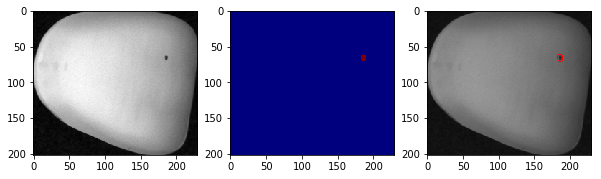

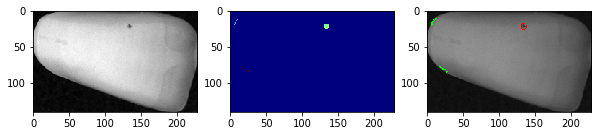

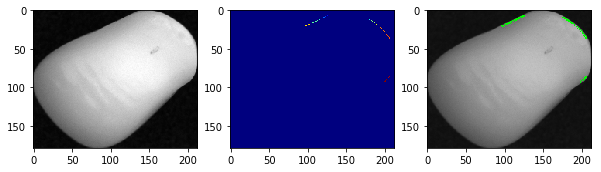

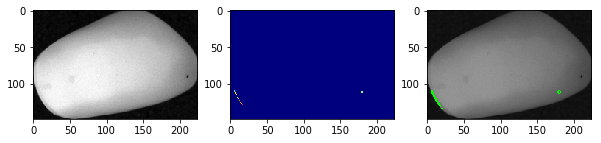

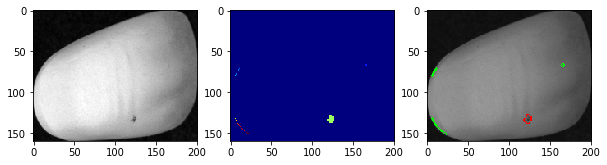

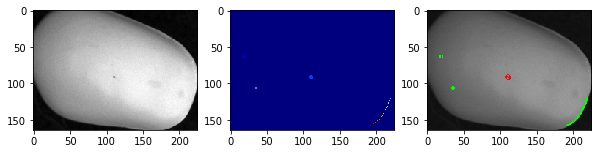

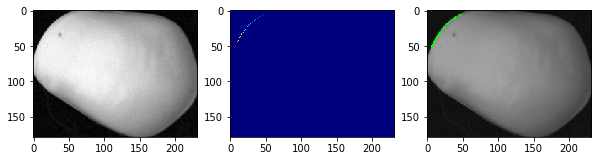

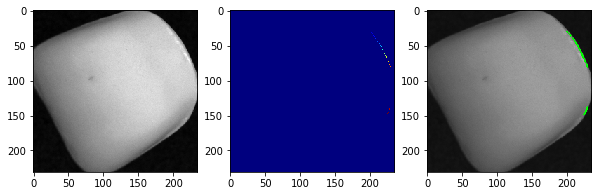

In [18]:
# Procesamos algunas imágenes de dientes con defectos
for i in range(10):
    #Para las imagenes sin recortar
    img_color = io.imread("TeethDataset/Dientes_SinGroundTruth/Sucios/"+str(i+1)+".bmp")
    img = color.rgb2gray(img_color)
    img = recortarDiente(img)
    
    img_2 = preprocesarDiente(img)
    label_img = segmentarDefectos(img_2)
    
    #Se extraen las caracterrísticas de cada uno de los objetos en la imagen obtenida
    a, b, Xn = obtenerCaracteristicas(label_img, img_2, gr_img=None, training=False)
    
    
    if not(a is None):

        M = np.unique(label_img)
        
        if (M.size <= 2):
            a = a.reshape(1,-1)
            
        #Escalamos el vector de datos obtenido
        a_std = scl.transform(a)
        
        #Se clasifican los objetos encontrados con el clasificador entrenado
        y_predicted = clf.predict(a_std)
        
        j = 0
        img_color = img.copy();
        for i in M:
            if i != 0:
                cp_label_image = label_img.copy()
                cp_label_image[cp_label_image != i]=0

                if y_predicted[j] == 0:
                    img_color = segmentation.mark_boundaries(img_color, cp_label_image, color=(0, 1, 0))
                else:
                    img_color = segmentation.mark_boundaries(img_color, cp_label_image, color=(1, 0, 0))
                j = j+1
        
        fig, ax = plt.subplots(1,3, figsize=(10,8))
        ax[0].imshow(img, cmap="gray")
        ax[1].imshow(label_img, cmap="jet")
        ax[2].imshow(img_color, cmap="gray")

        plt.show()
    
        #Sobreponemos los objetos en la imagen original: ROJO defecto, VERDE no defecto
        #img_color = segmentation.mark_boundaries(img, label_img, color=(1, 1, 0), outline_color=None, mode='outer', background_label=0)
    